In [26]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, KBinsDiscretizer
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import joblib

# load and clean data
def load_data(filepath):
    data = []
    with open(filepath, 'r') as fh:
        for line in fh:
            cleaned_line = line.strip().replace('[', '').replace(']', '').split()
            data.append(cleaned_line)
    return np.array(data, dtype=np.float64)

# add time feature of 10 min increments
def add_time_features(data, timestamps):
    time_features = []
    for ts in timestamps:
        day = ts // (24 * 60)  # idex for day
        minute_of_day = ts % (24 * 60)  # mins per day
        interval = minute_of_day // 10  # index 10 min interval
        time_features.append([day, interval])
    return np.hstack((data, np.array(time_features)))

# timestamps
def generate_timestamps(num_samples, interval_minutes=5): 
    return np.arange(0, num_samples * interval_minutes, interval_minutes)

# load datasets
print('_Load dataset.')
npTrainingSet = load_data('PEMS_train')
npTrainingLabelSet = load_data('PEMS_trainlabels').ravel()
npTestSet = load_data('PEMS_test')
npTestLabelSet = load_data('PEMS_testlabels').ravel()

# timestamps
print('_Generate timestamps.')
interval_minutes = 5  # Define the interval between samples
training_timestamps = generate_timestamps(npTrainingSet.shape[0], interval_minutes)
test_timestamps = generate_timestamps(npTestSet.shape[0], interval_minutes)

# time-based features
print('_Add time-based features.\n')
npTrainingSet = add_time_features(npTrainingSet, training_timestamps)
npTestSet = add_time_features(npTestSet, test_timestamps)

# test with sample size
sample_size = 5000   
npTrainingSet = npTrainingSet[:sample_size]
npTrainingLabelSet = npTrainingLabelSet[:sample_size]
print(f'Train data shape: {npTrainingSet.shape}')
print(f'Train labels shape: {npTrainingLabelSet.shape}')

# transform and normalize data
print('\n_Transform and normalize data.')
tf = TfidfTransformer()
nl = Normalizer(copy = False)
pipeline = make_pipeline(tf, nl)

tfNnlnpTrainData = pipeline.fit_transform(npTrainingSet)
tfNnlnpTestSet = pipeline.transform(npTestSet)
print(f'Shape after TF-IDF and normalized (Train): {tfNnlnpTrainData.shape}')
print(f'Shape after TF-IDF and normalized (Test): {tfNnlnpTestSet.shape}')

# dimensionality reduction w/ PCA
print('\n_Dimensionality reduction with incremental PCA\n')
nComponents = 25  
ipca = IncrementalPCA(n_components = nComponents, batch_size = 5000)
reducedtfNnlnpTrainData = ipca.fit_transform(tfNnlnpTrainData)
reducedtfNnlnpTestSet = ipca.transform(tfNnlnpTestSet)
print(f'Shape (reduced train data): {reducedtfNnlnpTrainData.shape}')
print(f'Shape (reduced test data): {reducedtfNnlnpTestSet.shape}')

# approx target values to bins
print('\n_Allocate target values to bins')
discretizer = KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'uniform', subsample = None)
binned_training_labels = discretizer.fit_transform(npTrainingLabelSet.reshape(-1, 1)).ravel()
binned_test_labels = discretizer.transform(npTestLabelSet.reshape(-1, 1)).ravel()

# ADASYN - balancing classes
print('_Balance class with ADASYN.\n')
adasyn = ADASYN(random_state = 11)
balanced_train_data, balanced_train_labels = adasyn.fit_resample(reducedtfNnlnpTrainData, binned_training_labels)
print(f'Balanced Training Data Shape: {balanced_train_data.shape}')
print(f'Balanced Class Distribution: {np.bincount(balanced_train_labels.astype(int))}')

# Random Forest w/ hyperparameter tuning using RandomizedSearchCV 
print('\n_Tune RandomForest hyperparameters with RandomizedSearchCV.\n')
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced']}

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state = 11, n_jobs = -1),
    rf_param_grid, n_iter = 20, scoring = 'f1_weighted', cv = 5, verbose = 2, n_jobs = -1)

rf_random_search.fit(balanced_train_data, balanced_train_labels)
best_rf_classifier = rf_random_search.best_estimator_
print(f'\nBest Random Forest parameters: {rf_random_search.best_params_}\n')

# LightGBM with hyperparameter tuning using RandomizedSearchCV 
print('_TuneLightGBM hyperparameters with RandomizedSearchCV.')
lgbm = LGBMClassifier(random_state = 11, device = 'gpu')   
lgbm_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 50, 100]}

lgbm_random_search = RandomizedSearchCV(
    lgbm, lgbm_param_grid, n_iter = 20, scoring = 'f1_weighted', cv = 5, verbose = 2, n_jobs = -1)

lgbm_random_search.fit(balanced_train_data, balanced_train_labels)
best_lgbm_classifier = lgbm_random_search.best_estimator_
print(f'Best LightGBM parameters: {lgbm_random_search.best_params_}')

# ensemble voting classifier
print('\n_Train voting classifier.')
voting_clf = VotingClassifier(
    estimators = [('rf', best_rf_classifier), ('lgbm', best_lgbm_classifier)], voting = 'soft')
voting_clf.fit(balanced_train_data, balanced_train_labels)

# cross-validate F1 
print('_Evaluate with stratistified cross-validation.')
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 11)
cv_scores = cross_val_score(voting_clf, balanced_train_data, balanced_train_labels, cv = cv, scoring = 'f1_weighted')
print(f'\nStratified Cross-Validation F1-Score: {cv_scores.mean():.4f}')

# Prediction on test data
print('\n_Traffic prediction categories w/ test data.')
test_predictions = voting_clf.predict(reducedtfNnlnpTestSet)


_Load dataset.
_Generate timestamps.
_Add time-based features.

Train data shape: (267, 138674)
Train labels shape: (267,)

_Transform and normalize data.
Shape after TF-IDF and normalized (Train): (267, 138674)
Shape after TF-IDF and normalized (Test): (173, 138674)

_Dimensionality reduction with incremental PCA

Shape (reduced train data): (267, 25)
Shape (reduced test data): (173, 25)

_Allocate target values to bins
_Balance class with ADASYN.

Balanced Training Data Shape: (375, 25)
Balanced Class Distribution: [127 125 123]

_Tune RandomForest hyperparameters with RandomizedSearchCV.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Random Forest parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}

_TuneLightGBM hyperparameters with RandomizedSearchCV.
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightG

In [27]:
# evaluate model
test_f1 = f1_score(binned_test_labels, test_predictions, average = 'weighted')
print(f'F1-Score (Test): {test_f1:.4f}\n')
print(f'\nClassification Report (Test):\n', classification_report(binned_test_labels, test_predictions))
print(f'\nConfusion Matrix (Test):\n{confusion_matrix(binned_test_labels, test_predictions)}')

# save trained model
joblib.dump(voting_clf, 'traffic_prediction_ensemble_optimized.pkl')
print('_Optimized ensemble model saved.')

F1-Score (Test): 0.8203


Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.86      0.76      0.81        55
         1.0       0.85      0.80      0.82        49
         2.0       0.78      0.88      0.83        69

    accuracy                           0.82       173
   macro avg       0.83      0.81      0.82       173
weighted avg       0.82      0.82      0.82       173


Confusion Matrix (Test):
[[42  2 11]
 [ 4 39  6]
 [ 3  5 61]]
_Optimized ensemble model saved.


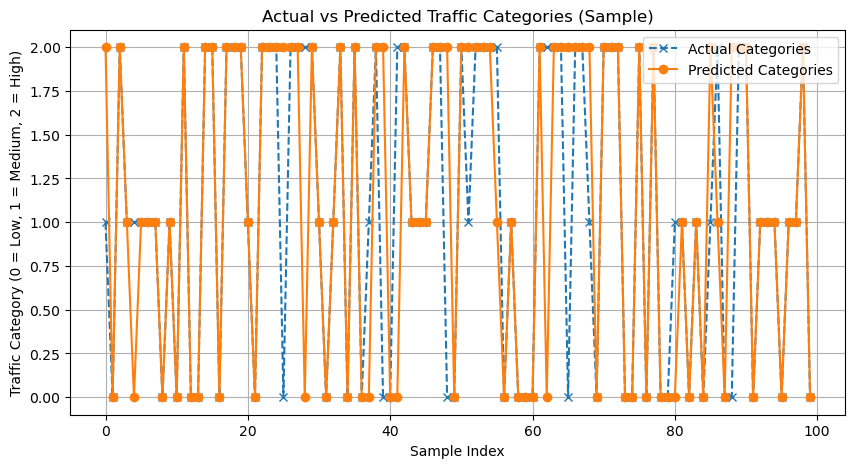

In [28]:
# plot predictions
plt.figure(figsize = (10, 5))
plt.plot(binned_test_labels[:100], label = 'Actual Categories', marker='x', linestyle='--')
plt.plot(test_predictions[:100], label = 'Predicted Categories', marker='o', linestyle='-')
plt.title('Actual vs Predicted Traffic Categories (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Category (0 = Low, 1 = Medium, 2 = High)')
plt.legend()
plt.grid()
plt.show()